In [ ]:
# Make sure GPU enviroment is set|
!nvidia-smi

Sat May 11 18:45:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   30C    P8              11W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from IPython.display import clear_output
!pip install -U ultralytics roboflow supervision twilio
clear_output()
!yolo checks

Ultralytics YOLOv8.2.12 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Setup complete ✅ (16 CPUs, 62.8 GB RAM, 30.0/201.2 GB disk)

OS                  Linux-6.1.58+-x86_64-with-glibc2.35
Environment         Colab
Python              3.10.12
Install             pip
RAM                 62.80 GB
CPU                 Intel Xeon 2.20GHz
CUDA                12.1

matplotlib          ✅ 3.7.1>=3.3.0
opencv-python       ✅ 4.8.0.76>=4.6.0
pillow              ✅ 9.4.0>=7.1.2
pyyaml              ✅ 6.0.1>=5.3.1
requests            ✅ 2.31.0>=2.23.0
scipy               ✅ 1.11.4>=1.4.1
torch               ✅ 2.2.1+cu121>=1.8.0
torchvision         ✅ 0.17.1+cu121>=0.9.0
tqdm                ✅ 4.66.4>=4.64.0
psutil              ✅ 5.9.5
py-cpuinfo          ✅ 9.0.0
thop                ✅ 0.1.1-2209072238>=0.1.1
pandas              ✅ 2.0.3>=1.1.4
seaborn             ✅ 0.13.1>=0.11.0


In [ ]:
import cv2
import io
import numpy as np
import shutil
import supervision as sv
import yaml
import PIL
import matplotlib.pyplot as plt
import roboflow
import requests
from requests.auth import HTTPBasicAuth
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
from ultralytics.engine.results import Results
from google.colab import files
from google.colab.output import eval_js
from IPython.display import display, Javascript
from base64 import b64decode, b64encode
from typing import List

In [ ]:
# Download ltttnt/fire-vqbia (Fire Dataset) from Robofolow
rf = roboflow.login()
project = rf.workspace("ltttnt").project("fire-vqbia")
version = project.version(1)
dataset = version.download("yolov8")

In [ ]:
# Update the data.yaml file to include the actual paths of test,train,val
# !MAKE SURE TO MODIFY THE ABSOLUTE PATHS AS NEEDED!
data_file_path = f'{dataset.location}/data.yaml'
# Absolute paths
new_test_path  = "/content/FIRE-1/test/images"
new_train_path = "/content/FIRE-1/train/images"
new_val_path   = "/content/FIRE-1/valid/images"

with open(data_file_path,'r') as data_file:
  data = yaml.safe_load(data_file)


# Modify the values
new_values = {
    "test": new_test_path,
    "train": new_train_path,
    "val": new_val_path
}

data.update(new_values)

# Convert back to YAML
modified_data = yaml.safe_dump(data, sort_keys=False)

with open(data_file_path,'w') as data_file:
  data_file.write(modified_data)

print(f"Updated: {data_file_path}.")
print(f"To the follwoing:\n\n{modified_data}")

In [ ]:
# Load a model
#model = YOLO('yolov8n.yaml')  # build a new model from YAML
model = YOLO('yolov8x.pt')  # load a pretrained model (recommended for training)
#model = YOLO('yolov8n.yaml').load('yolov8n.pt')  # build from YAML and transfer weights
# Train the model
results = model.train(data=f'{dataset.location}/data.yaml', epochs=100, imgsz=640)

In [ ]:
metrics = model.val()
print(metrics.maps)

In [ ]:
# Download Trained Model Data

# Create a zip file from the 'runs' directory
shutil.make_archive('/content/runs', 'zip', '/content/runs')

# Download the created zip file
files.download('/content/runs.zip')

In [ ]:
import os
from pathlib import Path
from google.colab import drive
from IPython.display import clear_output

# Configuration and paths
drive_mount_path = '/content/drive'
project_folder_name = 'SeniorProject2Data'
local_target_path = Path('/content')

# User-friendly messages
print("Accessing/Pulling Senior Project Data from Google Drive...")
print("Note: This will only work for senior project students with access to the correct directory.")
print("Requesting Access to Google Drive...")

# Mount Google Drive
drive.mount(drive_mount_path, force_remount=True)  # Force remount option

# Define paths
senior_project_path = Path(f"{drive_mount_path}/MyDrive/{project_folder_name}")
target_directory = local_target_path

# Check if the Google Drive is mounted and if the specific project directory exists
if not senior_project_path.is_dir():
    print("Senior Project directory not found within your drive. Aborting!")
else:
    # Copying files to the local /content directory on Colab
    print(f"Found Senior Project directory. Preparing to move files...")
    for file_path in senior_project_path.glob('*'):
        destination = target_directory / file_path.name
        if not destination.exists():
            os.system(f'cp -r "{file_path}" "{destination}"')

    # Handling ZIP files specifically
    zip_files = list(target_directory.glob('*.zip'))
    if not zip_files:
        print("No zip files to unzip.")
    else:
        print("Unzipping files...")
        for zip_path in zip_files:
            directory_name = zip_path.stem  # File name without the '.zip' extension
            directory_path = target_directory / directory_name
            directory_path.mkdir(exist_ok=True)  # Create a directory for the files
            os.system(f'unzip -o "{zip_path}" -d "{directory_path}"')  # Unzip files into the directory
            zip_path.unlink()  # Remove the zip file after extraction

    clear_output(wait=True)
    print("Operation completed. Here are the details:")
    print("Files moved from Google Drive:")
    for file in senior_project_path.glob("*"):
        print(f"- {file.name}")
    print("Unzipped the following directories:")
    for zip_file in zip_files:
        print(f"- {zip_file.stem}")
    print("Original zip files have been removed after extraction.")


Operation completed. Here are the details:
Files moved from Google Drive:
- FIRE_YOLOX_MODEL.zip
- FIRE_YOLON_MODEL.zip
- fire_test_image.jpg
Unzipped the following directories:
- FIRE_YOLOX_MODEL
- FIRE_YOLON_MODEL
Original zip files have been removed after extraction.


In [ ]:
model_path = "/content/FIRE_YOLOX_MODEL/detect/train/weights/best.pt"
model = YOLO(model_path)


0: 448x640 1 fire - v1 2023-05-30 2-36pm, 149.3ms
Speed: 5.9ms preprocess, 149.3ms inference, 3088.7ms postprocess per image at shape (1, 3, 448, 640)


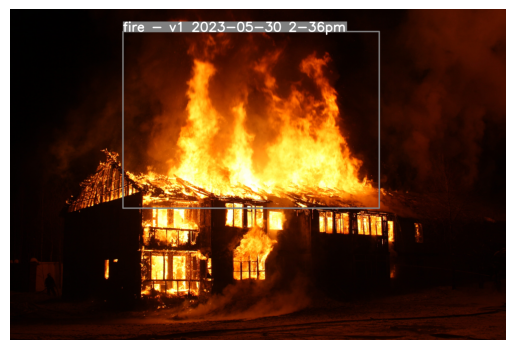

In [ ]:
img = cv2.imread("/content/fire_test_image.jpg")
results = model.predict(img)


for r in results:

    annotator = Annotator(img)

    boxes = r.boxes
    for box in boxes:

        b = box.xyxy[0]  # get box coordinates in (left, top, right, bottom) format
        c = box.cls
        annotator.box_label(b, model.names[int(c)])

img = cv2.cvtColor(annotator.result(), cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

  # JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Function to format Saudi phone number for WhatsApp
def format_saudi_number_for_whatsapp(phone_number):
    # Remove all non-digit characters
    digits_only = ''.join(filter(str.isdigit, phone_number))
    # Check length and format accordingly
    if len(digits_only) == 12 and digits_only.startswith("966"):
        # Correct format with country code
        normalized_number = digits_only
    elif len(digits_only) == 9:
        # Local number without leading zero or country code
        normalized_number = "966" + digits_only
    elif len(digits_only) == 10 and digits_only.startswith("05"):
        # Local number with leading zero
        normalized_number = "966" + digits_only[1:]
    else:
        # Invalid number length or format, raise an exception or handle it
        raise ValueError("Provided phone number is invalid or not in a recognized Saudi format.")
    return normalized_number

# Text input widget for phone number
text_input = widgets.Text(
    value='',
    placeholder='+966500000000',
    description='Enter a Saudi Phone Number:',
    disabled=False
)

# Global variable to store the formatted phone number
user_phone_number = ''

# Function to handle input changes and update global variable
def handle_input_change(change):
    global user_phone_number  # Declare to modify the global variable
    try:
        user_phone_number = format_saudi_number_for_whatsapp(change['new'])
        print(user_phone_number)  # Output the formatted number
    except ValueError as e:
        print(e)  # Print the error if the number is invalid

# Observing the text input for changes
text_input.observe(handle_input_change, names='value')

# Display the text input widget
display(text_input)

Text(value='', description='Enter a Saudi Phone Number:', placeholder='+966500000000')

Provided phone number is invalid or not in a recognized Saudi format.
Provided phone number is invalid or not in a recognized Saudi format.
Provided phone number is invalid or not in a recognized Saudi format.
Provided phone number is invalid or not in a recognized Saudi format.
966544032211
Provided phone number is invalid or not in a recognized Saudi format.
Provided phone number is invalid or not in a recognized Saudi format.
Provided phone number is invalid or not in a recognized Saudi format.
Provided phone number is invalid or not in a recognized Saudi format.
966554033211


In [ ]:
def send_wa_message(message:str,to:str):
  url = "https://messages-sandbox.nexmo.com/v1/messages"

  headers = {
      "Content-Type": "application/json",
      "Accept": "application/json"
  }

  data = {
      "from": "14157386102",
      "to": to,
      "message_type": "text",
      "text": message,
      "channel": "whatsapp"
  }

  response = requests.post(url, auth=HTTPBasicAuth('bcc9030a', 'n8taLkrI2EIqCoJC'), headers=headers, json=data)
  return response

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])
    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    object_count = 0
    results:List[Results] = model.predict(img,verbose=False)
    for result in results:
      if len(result.boxes) > 0:
        send_wa_message("Fire Detected!!!! WARNING !!!!",user_phone_number)
      boxes = result.boxes.cpu().numpy()
      xyxys = boxes.xywh
      for xyxy in xyxys:
        bbox_array = cv2.rectangle(bbox_array,(int(xyxy[0]),int(xyxy[1])),(int(xyxy[0])+int(xyxy[2]),int(xyxy[1])+int(xyxy[3])),(255,0,0),2)
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>